### Multiple Linear Regression

In this notebook, we will explore the application of Multiple Linear Regression to predict house prices.

We will work with a housing dataset that includes various features such as GrLivArea, Street, LotArea, and many others. Our objective remains the same: to predict the sale price of houses. However, unlike simple linear regression, where predictions are based on a single feature, we will leverage multiple features to make our predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scratch_libraries.linear_regression import LinearRegression

from scratch_libraries.utilities import plot_theta_gd
from scratch_libraries.evaluation_metrics import RegressionMetrics

In [2]:
# read the dataset of houses prices
houses = pd.read_csv('./datasets/houses.csv')

display(houses)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


In [3]:
# print dataset stats
print(houses.describe())

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

In [4]:
# shuffling all samples to avoid group bias
houses = houses.sample(frac=1, random_state=123).reset_index(drop=True)

Since the dataset contains numerous features, we will select a subset for our analysis. Specifically, we will use GrLivArea, LotArea, GarageArea, and FullBath as our features. The target variable for our prediction will be SalePrice.

In [5]:
# select only some features, also you can try with other features
x = houses[['GrLivArea', 'LotArea', 'GarageArea', 'FullBath']].values

# select target value
y = houses['SalePrice'].values

We split the dataset into training set and testing set using an 80/20 hold-out split. The first 80% of the data will be used for training the model, while the remaining 20% will be reserved for testing the model performance.

Therefore, we will use the training set to train our model and then will test it making some predictions on test set features and comparing them with the actual target values.

In [6]:
# in order to perform hold-out splitting 80/20 identify max train index value
train_index = round(len(x) * 0.8)

# split dataset into training and test
X_train = x[:train_index]
y_train = y[:train_index]

X_test = x[train_index:]
y_test = y[train_index:]

Before training, we apply Z-Score Normalization to normalize the features. It is crucial to compute the mean and standard deviation **exclusively from the training set** to avoid data leakage. These values are then used to normalize both the training and testing sets, ensuring consistency while preserving the integrity of the testing data.

In [7]:
# compute mean and standard deviation ONLY ON TRAINING SAMPLES
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# apply mean and std (standard deviation) computed on training sample to both training set and test set
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

We add a column of ones to $ x $ to enable the model to learn an intercept (bias).

In [8]:
# add bias column
X_train = np.c_[np.ones(X_train.shape[0]), X_train]
X_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [9]:
print(len(X_train))

1168


We create an istance of our Multiple Linear Regression model and we train it applying full Batch Gradient Descent (BGD).

In [10]:
# create a regressor with specific characteristics
linear = LinearRegression(n_features=X_train.shape[1], n_steps=100, learning_rate=0.05)

# fit (try different strategies) your trained regressor
cost_history, theta_history = linear.fit_fbgd(X_train, y_train)

print(f'''Thetas: {*linear.theta,}''')
print(f'''Final train cost:  {cost_history[-1]:.3f}''')

Thetas: (179910.67448524892, 35343.257349381944, 5867.901725711807, 28110.70494671874, 10387.44469770288)
Final train cost:  1146361249.920


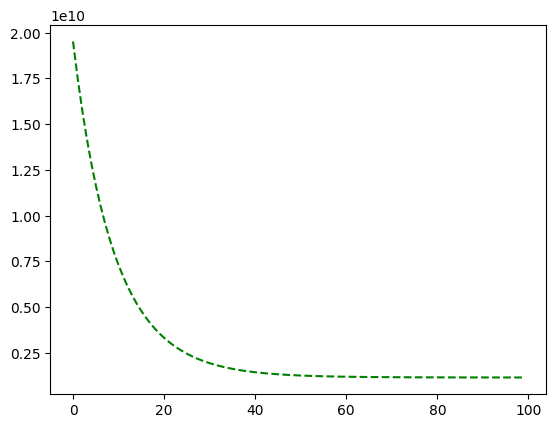

In [11]:
plt.plot(cost_history, 'g--')
plt.show()

After training the model, we assess its performance by testing it on the unseen data in the test set. This evaluation helps determine whether the parameters learned during training enable the model to generalize effectively to new data. To do this, we first make predictions on the test set features using the hypothesis function with the final learned parameters. We then compare these predictions with the actual target values from the test set. By calculating various regression metrics, such as mean absolute error (MAE), mean absolute percentage error (MAPE), mean percentage error (MPE), mean squared error (MSE), root mean squared error (RMSE), and the coefficient of determination (R²), we can quantitatively evaluate the model's performance.

In [12]:
reg_metrics = RegressionMetrics(linear)
y_pred = linear.predict(X_test)

print(reg_metrics.compute_performance(y_test, y_pred)) # compute various performance metrics

{'mae': 32514.856835321563, 'mape': 18.909214056966807, 'mpe': 3.9265936498067964, 'mse': 2702744363.687258, 'rmse': 51987.92517197871, 'r2': 0.5769454100565818}


Below we have two plots showing the progression of gradient descent on the cost function as the model’s parameters (theta) update over iterations.

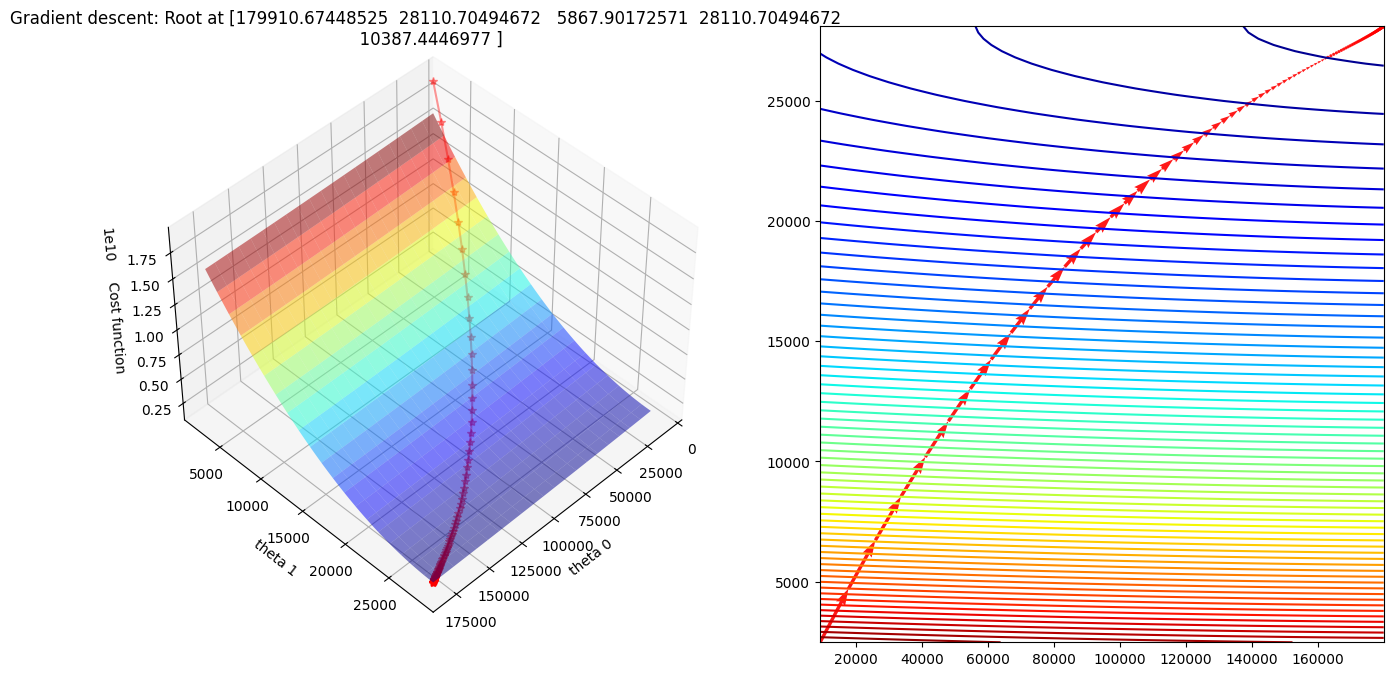

In [13]:
plot_theta_gd(X_train, y_train, linear, cost_history, theta_history, 0, 3) # It provides both a 3D surface plot and a 2D contour plot of the cost function.

Below, we also present the results we would obtain using Stochastic Gradient Descent (SGD) and Mini-Batch Gradient Descent (MBGD). Let's briefly recall the key differences:

- **Stochastic Gradient Descent (SGD):**
  In SGD, only one sample randomly chosen is used to update the parameters at each iteration:
  
  $$
  \theta_j \leftarrow \theta_j - \alpha \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
  $$

  SGD typically converges faster to an approximate solution than BGD. However, since each update is based on only one sample, the algorithm may oscillate ("zig-zag" effect) and potentially miss the exact minimum. Despite this, for large datasets, SGD is often preferred since it can find a solution that is close to optimal much more quickly.

- **Mini-Batch Gradient Descent (MBGD):**
  In MBGD a small batch of $b$ samples randomly chosen are used to update the parameters at each iteration, where $1 < b \ll m$:

  $$
  \theta_j \leftarrow \theta_j - \alpha \frac{1}{b} \sum_{i=1}^b \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)}
  $$

  MBGD strikes a balance between the speed of SGD and the stability of BGD. It tends to converge faster than BGD while being more stable than SGD, making it a popular choice when the dataset is large.



Thetas: (172233.78477315351, 42021.05239428033, 5464.737037638439, 42422.190454464435, 9769.067556331705))
 Final Train cost:  1337289717.449714


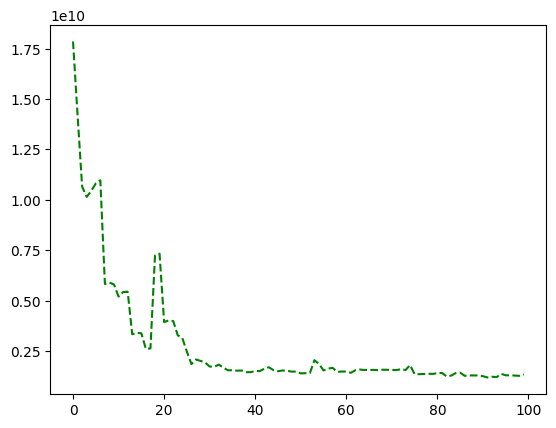

{'mae': 39090.50306307673, 'mape': 24.95476127013624, 'mpe': -5.33223437118915, 'mse': 3477585825.3178005, 'rmse': 58971.05921821144, 'r2': 0.4556611919760891}


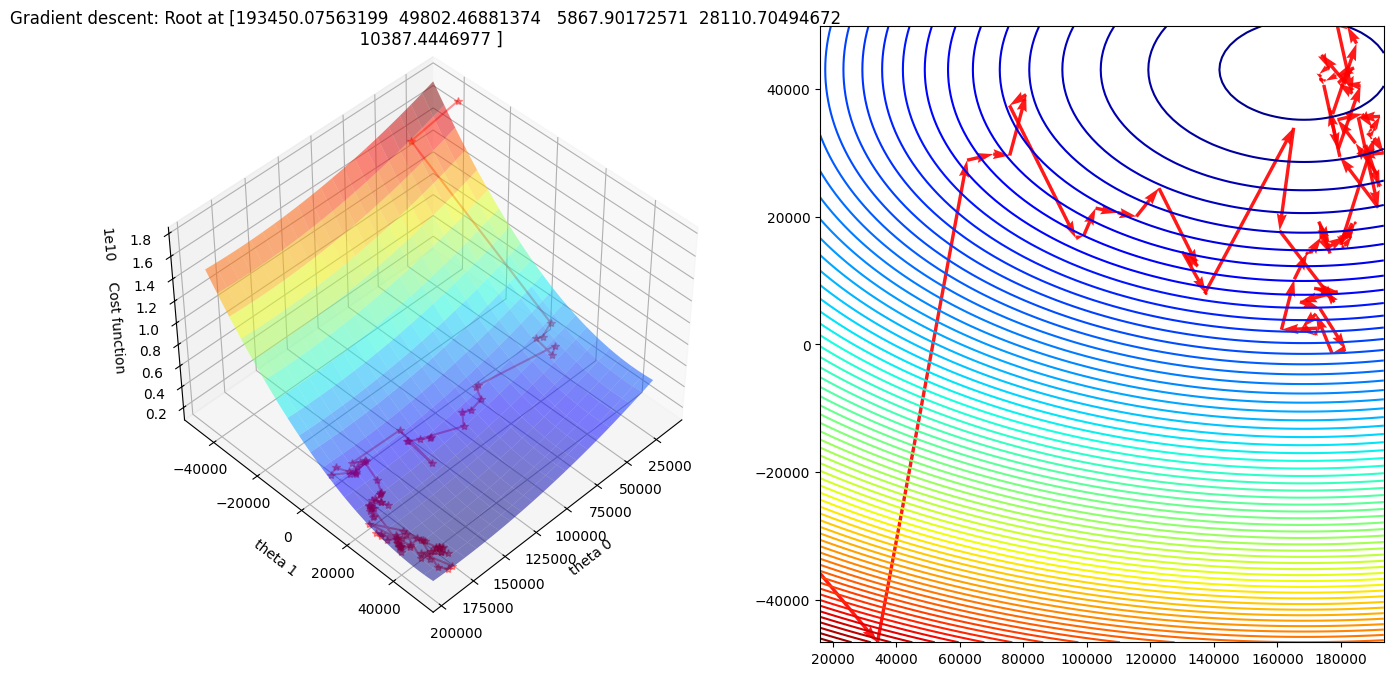

In [14]:
# SGD
linear_true_sgd = LinearRegression(n_features=X_train.shape[1], n_steps=100, learning_rate=0.1)

cost_history_true_sgd, theta_history_true_sgd = linear_true_sgd.fit_sgd(X_train, y_train)

print(f'''Thetas: {*linear_true_sgd.theta,})''')
print(f''' Final Train cost: {cost_history_true_sgd[-1]: 3f}''')

plt.plot(cost_history_true_sgd, 'g--')
plt.show()

print(RegressionMetrics(linear_true_sgd).compute_performance(y_test, linear_true_sgd.predict(X_test)))

plot_theta_gd(X_train, y_train, linear, cost_history_true_sgd, theta_history_true_sgd, 0, 3)

Thetas: (113785.81908547612, 23613.40502640004, 7451.740710983476, 23303.044113222266, 12061.977197319698))
 Final Train cost:  3502890314.659104


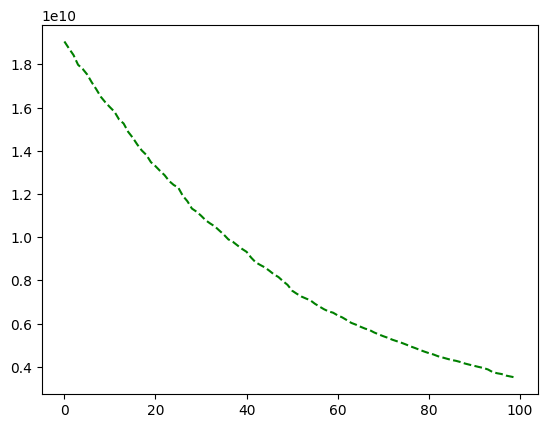

{'mae': 39090.50306307673, 'mape': 24.95476127013624, 'mpe': -5.33223437118915, 'mse': 3477585825.3178005, 'rmse': 58971.05921821144, 'r2': 0.4556611919760891}


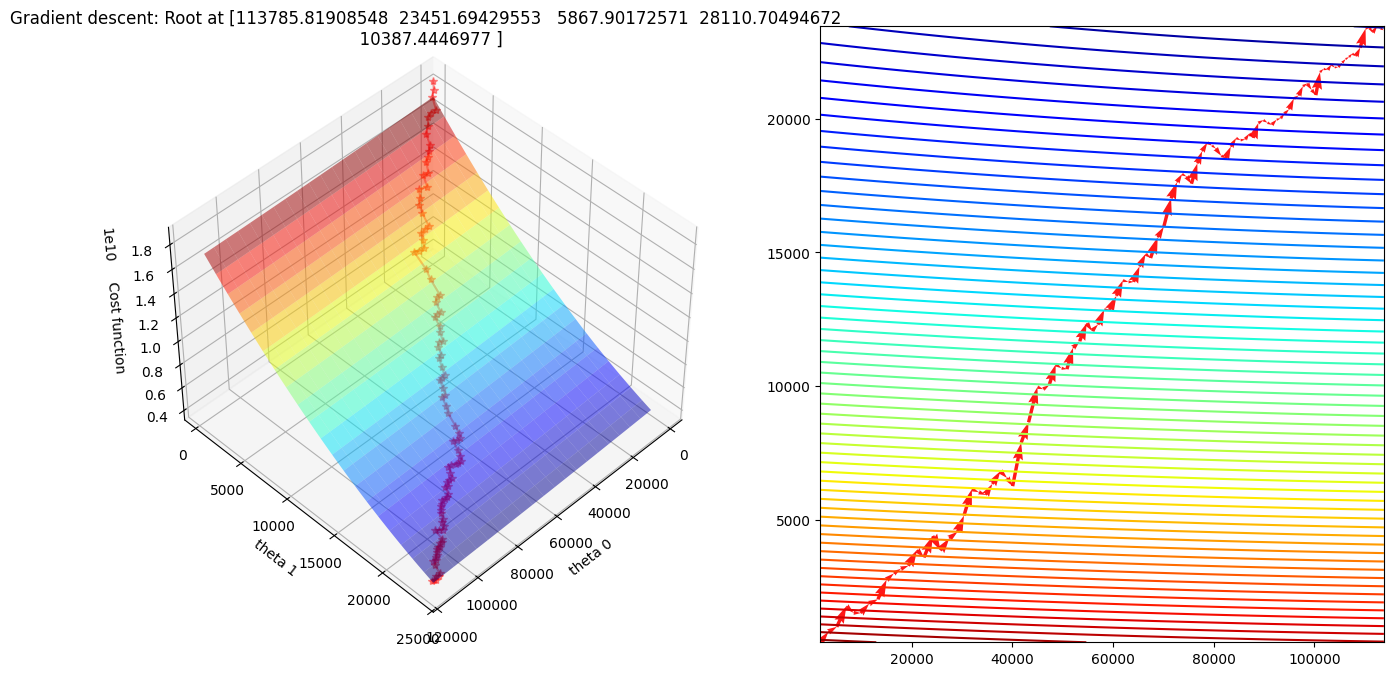

In [15]:
# MBGD
linear_true_mbgd = LinearRegression(n_features=X_train.shape[1], n_steps=100, learning_rate=0.01)

cost_history_true_mbgd, theta_history_true_mbgd = linear_true_mbgd.fit_mbgd(X_train, y_train, batch_size=16)

print(f'''Thetas: {*linear_true_mbgd.theta,})''')
print(f''' Final Train cost: {cost_history_true_mbgd[-1]: 3f}''')

plt.plot(cost_history_true_mbgd, 'g--')
plt.show()

print(RegressionMetrics(linear_true_mbgd).compute_performance(y_test, linear_true_sgd.predict(X_test)))

plot_theta_gd(X_train, y_train, linear, cost_history_true_mbgd, theta_history_true_mbgd, 0, 3)

---

Here we also report SGD and MBGD versions that make use of epochs, i.e they perform a complete pass over the training dataset without replacement.
In practical implementations these two versions are generally used since they are more stable.

Thetas: (180778.0419972458, 37354.500840171444, 5416.391088291487, 27594.931666991924, 8179.317515293683))
 Final Train cost:  1143930734.390072


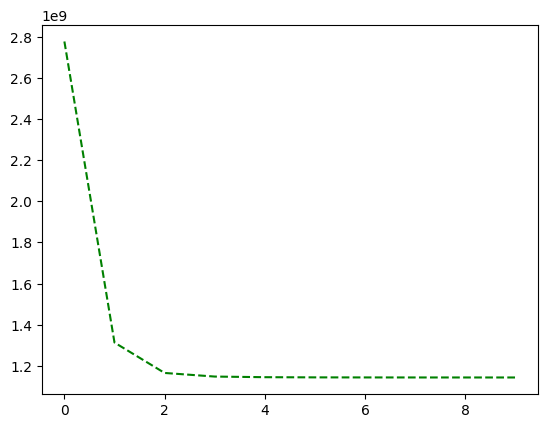

{'mae': 32513.49229993446, 'mape': 18.93777722941046, 'mpe': 4.5733951331623475, 'mse': 2734049418.901236, 'rmse': 52288.13841495255, 'r2': 0.5720452990898763}


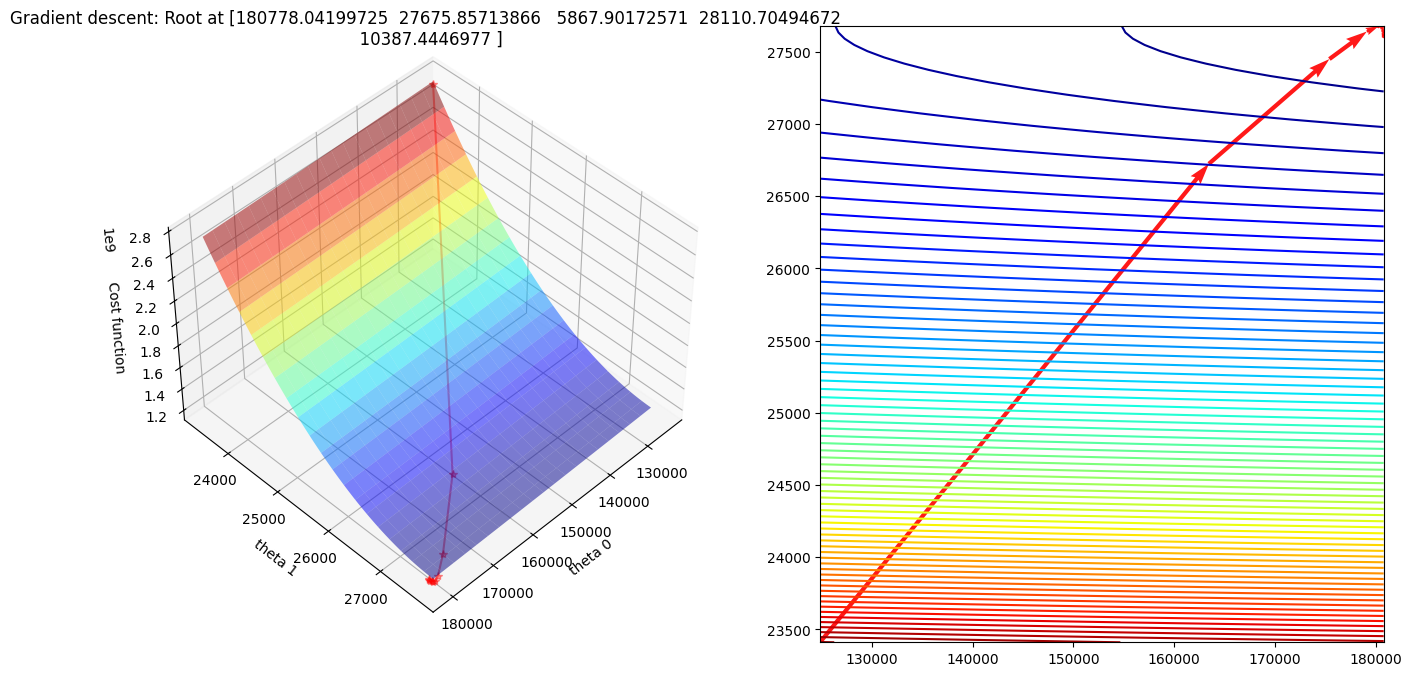

In [16]:
# SGD v2
linear_sgd = LinearRegression(n_features=X_train.shape[1], n_steps=10, learning_rate=0.001)

cost_history_sgd, theta_history_sgd = linear_sgd.fit_sgd_v2(X_train, y_train)

print(f'''Thetas: {*linear_sgd.theta,})''')
print(f''' Final Train cost: {cost_history_sgd[-1]: 3f}''')

plt.plot(cost_history_sgd, 'g--')
plt.show()

print(RegressionMetrics(linear_sgd).compute_performance(y_test, linear_sgd.predict(X_test)))

plot_theta_gd(X_train, y_train, linear, cost_history_sgd, theta_history_sgd, 0, 3)

Thetas: (180722.12518335955, 36502.28993819286, 5578.805623417805, 27917.935580099776, 9016.451612776242))
 Final Train cost:  1144184216.916667


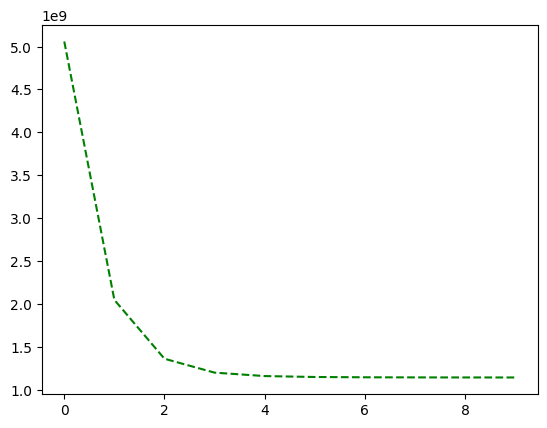

{'mae': 32527.28573340634, 'mape': 18.95842316414455, 'mpe': 4.4946575649430365, 'mse': 2720694946.416278, 'rmse': 52160.281310747145, 'r2': 0.5741356450940862}


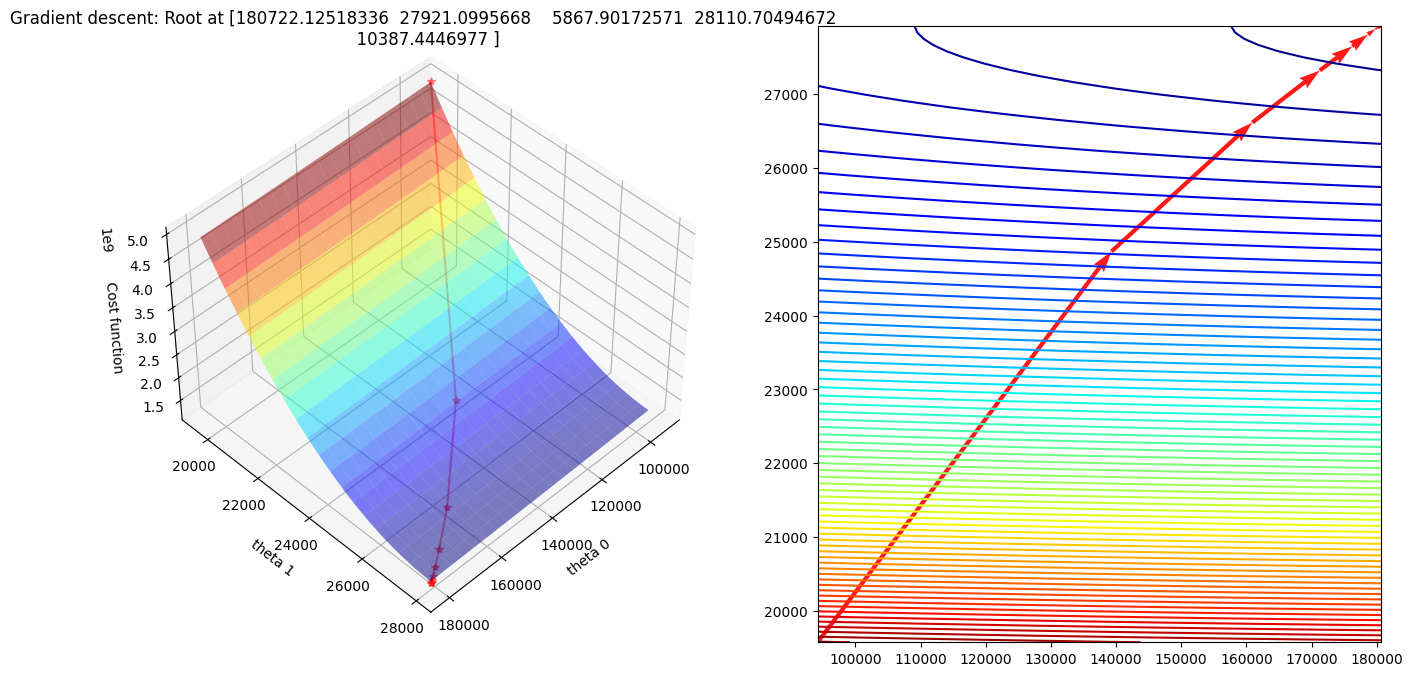

In [17]:
# MBGD
linear_mbgd = LinearRegression(n_features=X_train.shape[1], n_steps=10, learning_rate=0.01)

cost_history_mbgd, theta_history_mbgd = linear_mbgd.fit_mbgd_v2(X_train, y_train, batch_size=16)

print(f'''Thetas: {*linear_mbgd.theta,})''')
print(f''' Final Train cost: {cost_history_mbgd[-1]: 3f}''')

plt.plot(cost_history_mbgd, 'g--')
plt.show()

print(RegressionMetrics(linear_mbgd).compute_performance(y_test, linear_mbgd.predict(X_test)))

plot_theta_gd(X_train, y_train, linear, cost_history_mbgd, theta_history_mbgd, 0, 3)